In [2]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from sklearn.utils.extmath import randomized_svd

# Data

In [3]:
calendar = pd.read_csv('data/calendar.csv')
sales_train_validation = pd.read_csv('data/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('data/sales_train_evaluation.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
sell_prices = pd.read_csv('data/sell_prices.csv')

# Functions

In [4]:
def dynamic_mode_decomposition(data, rank):
    #data matrices
    X = data[:,:-1]
    Y = data[:,1:]

    #SVD
    U, Sigma, VT = randomized_svd(X, n_components=rank, random_state=None)

    #Koopman operator
    inv_Sigma = np.reciprocal(Sigma)
    A_tilde = U.T @ Y @ VT.T * inv_Sigma

    #DMD modes
    eig_values, W = LA.eig(A_tilde)
    eig_vectors = Y @ VT.T * inv_Sigma @ W #corresponds to eigenvectors of timestep operator A such that AX=Y
    
    return eig_values, eig_vectors

In [5]:
def dmd_forecast(data, rank, num_forecasts):
    eig_values, eig_vectors = dynamic_mode_decomposition(data, rank)
    diag_eig_values = np.diag(eig_values)

    initial_condition = data[:,-1] #uses last vector in data for initial condition
    data_length = initial_condition.shape[0]
    forecast_results = np.zeros((data_length, num_forecasts))

    #time stepping
    low_dim_forecast = LA.lstsq(eig_vectors, initial_condition, rcond=None)[0]
    for t in range(num_forecasts):
        low_dim_forecast = diag_eig_values @ low_dim_forecast
        forecast_t = (eig_vectors @ low_dim_forecast).real
        forecast_t[forecast_t<0] = 0 #set negative values in result to zero
        forecast_results[:,t] =  forecast_t
    return forecast_results

In [6]:
def submission_format(predicted_sales_validation, predicted_sales_evaluation):
    submission = sample_submission.copy()
    num_forecasts = 28
    submission[submission.columns[1:num_forecasts+1]] = np.concatenate((predicted_sales_validation, predicted_sales_evaluation), axis=0)
    return submission

# Forecasting

In [7]:
#validation
num_days_validation = 1913
num_products = len(sales_train_validation)
num_forecasts = 28
rank = 30

sales_validation = sales_train_validation.iloc[:,-num_days_validation:].to_numpy()
predicted_sales_validation = dmd_forecast(sales_validation, rank, num_forecasts)
predicted_sales_validation[predicted_sales_validation<0]=0 #set negative values to zero

In [8]:
#evaluation
num_days_evaluation = 1941
num_products = len(sales_train_evaluation)
num_forecasts = 28
rank = 10

sales_evaluation = sales_train_evaluation.iloc[:,-num_days_evaluation:].to_numpy()
predicted_sales_evaluation = dmd_forecast(sales_evaluation, rank, num_forecasts)

# Error Analysis

In [9]:
#all sales
true_sales = sales_train_evaluation.iloc[:,-num_forecasts:].to_numpy()
relative_error = LA.norm(true_sales-predicted_sales_validation)/LA.norm(true_sales)
relative_error

0.6028409576514543

# Plots

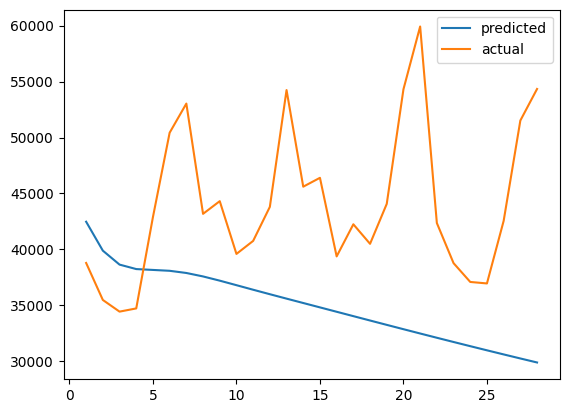

In [10]:
#all sales
forecast_days = np.arange(1,num_forecasts+1)
plt.plot(forecast_days, predicted_sales_validation.sum(axis=0), label = "predicted")
plt.plot(forecast_days, true_sales.sum(axis=0), label = "actual")
plt.legend()
plt.show()

# Submission

In [11]:
submission = submission_format(predicted_sales_validation, predicted_sales_evaluation)
submission.to_csv('submission/submission.csv',index=False)